In [2]:
# 1. Load & QC LAS File

import lasio
import pandas as pd
import matplotlib.pyplot as plt
las = lasio.read("ALTHORPE 1_MAIN_HR_Althorpe.las")

# Convert to dataframe
df = las.df()
df.index.name = 'Depth'

# Check available curves
print("Available curves:", list(df.columns))
df.head()

Available curves: ['CGXT', 'SMTU', 'GRGC', 'CCLG', 'FEFE', 'FEFR', 'NPOR', 'NPRL', 'NPRS', 'NPRD', 'CLDC', 'DENF', 'DENN', 'DCOR', 'DEN', 'PDPE', 'DPOR', 'DPRL', 'DPRS', 'DPRD', 'TR21', 'TR11', 'TR22', 'TR12', 'DT35', 'CLYC', 'DSLL', 'DDLL', 'DGLL', 'HVOL', 'AVOL', 'BIT']


,CGXT,SMTU,GRGC,CCLG,FEFE,FEFR,NPOR,NPRL,NPRS,NPRD,...,TR22,TR12,DT35,CLYC,DSLL,DDLL,DGLL,HVOL,AVOL,BIT
Depth,,,,,,,,,,,,,,,,,,,,,
4319.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4318.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.834,NaN,1444.141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.751,NaN,1441.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.668,NaN,1455.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5


In [3]:
# 2. Rename Key Curves (alias matching) - for easier matching

curves_aliases = {
    'GR': 'GRGC',       # Gamma Ray
    'RHOB': 'DEN',      # Density
    'PEF':'PDPE',       # Photoelectric
    'Caliper': 'CLDC',  # Borehole Diameter
    'DPOR': 'DPOR',     # Density Neutron
    'NPOR': 'NPOR',     # Porosity Neutron
    'RES': 'DDLL'       # Deep Resistivity
}

# Filter columns that exist & rename for consistency
available = [alias for alias in curves_aliases.values() if alias in df.columns]
df = df[available]

# (Optional) Check for missing expected logs
missing = [v for v in curves_aliases.values() if v not in df.columns]
if missing:
    print(f" Warning: Missing Curves from LAS File: {missing}")
    
# Rename to standard curve names (GR, RHOB, etc.)
df = df.rename(columns={v: k for k, v in curves_aliases.items()})

df.dropna(how='all', inplace=True)      # to discard rows contains NaN values (all NaN in a row is considered)

In [4]:
# 3. Coal Zone Criteria & Zonation

required_cols = ['GR', 'RHOB', 'PEF', 'DPOR', 'NPOR']   # Deep Resistivity (RES/DDLL) not so reliable in determining coal zonation unless with additional QC
if all(col in df.columns for col in required_cols):
    criteria = (
        (df['GR'] < 50) &
        (df['RHOB'] < 1.8) &
        (df['PEF']< 1.5) &
        (df['DPOR'] > 0.04) | (df['NPOR'] > 0.04)
    )
    df['is_coal'] = criteria.astype(int)
else:
    print("🍒 Not all required logs are available to define coal zone")


In [5]:
df_full = df.copy() # keep original full depth version

In [6]:
# 4. Plotting Porosity-Depth with Coal Zone Shading

def plot_porosity(df, top=None, base=None):
    df_plot = df.copy()
    
    # (Optional) Depth range filtering
    if top and base:
        df_plot = df_plot[(df_plot.index >= top) & (df_plot.index <= base)]
        
    # Check if still has data ( if tak ada data available, just gracefully exit ya)
    if df_plot.empty:
        print("🚩 No data in selected depth range")
        return

    fig2, ax2 = plt.subplots(ncols=2, figsize=(8, 8), sharey=True)
    fig2.suptitle("Porosity vs Depth with Coal Zone Highlight", fontsize=14)

    depth = df_plot.index if 'DEPTH' not in df_plot.columns else df_plot['DEPTH']      # rename DEPT to DEPTH (index=DEPT in .las)

    # Track 1 - Density Porosity (DPOR)
    ax2[0].plot(df_plot['DPOR'], depth, label='Density Porosity', color='brown')
    ax2[0].fill_betweenx(depth, df_plot['DPOR'], where=df_plot['is_coal'] == 1, color='green', alpha=0.3, label='Coal Zone')
    ax2[0].invert_yaxis()
    ax2[0].set_xlabel('DPOR')
    ax2[0].legend()
    ax2[0].grid()

    # Track 2 - Neutron Porosity (NPOR)
    ax2[1].plot(df_plot['NPOR'], depth, label='Neutron Porosity', color='purple')
    ax2[1].fill_betweenx(depth, df_plot['NPOR'], where=df_plot['is_coal'] == 1, color='green', alpha=0.3)
    ax2[1].set_xlabel('NPOR')
    ax2[1].legend()
    ax2[1].grid()

    plt.tight_layout()
    plt.show()

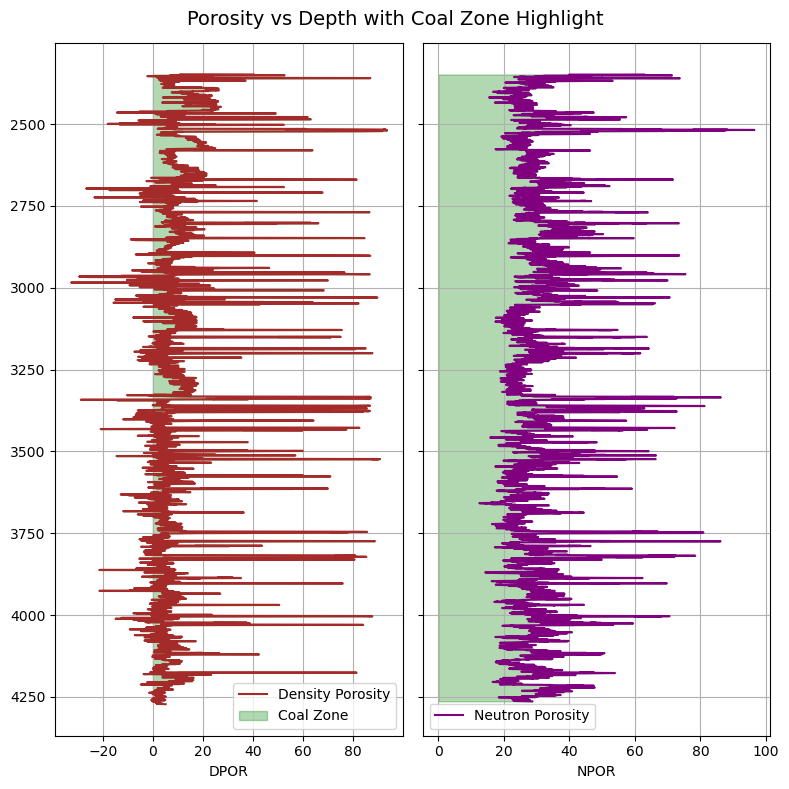

In [7]:
# 4a. Plotting for Whole Range of Depth
plot_porosity(df_full)

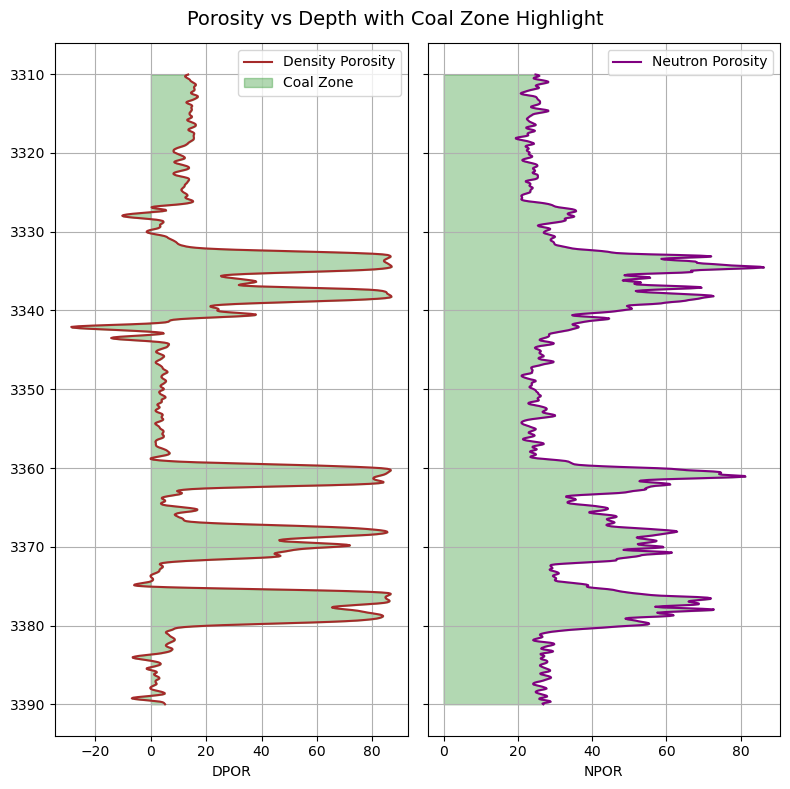

In [8]:
# 4b. Plotting for Subset depth range
plot_porosity(df_full, top=3310, base=3390)

In [9]:
# 5. Plotting Porosity Track (Overlay DPOR x NPOR with Coal Shading)

def plot_overlay_porosity(df, top=None, base=None):
    df_plot = df.copy()
    
    # (Optional) Depth range filtering
    if top and base:
        df_plot = df_plot[(df_plot.index >= top) & (df_plot.index <= base)]
        
    # Check if still has data ( if tak ada data available, just gracefully exit ya)
    if df_plot.empty:
        print("🚩 No data in selected depth range")
        return
    
    fig, ax = plt.subplots(figsize=(4, 8))
    
    depth = df_plot.index if 'DEPTH' not in df_plot.columns else df_plot['DEPTH']
    
    # Plotting porosity logs
    ax.plot(df_plot['DPOR'], depth, label='DPOR (Density)', color='maroon')
    ax.plot(df_plot['NPOR'], depth, label='NPOR (Neutron)', color='blue')
    
    # Shading for coal zone
    ax.fill_betweenx(
        depth,
        df_plot[['DPOR', 'NPOR']].min(axis=1),
        df_plot[['DPOR', 'NPOR']].max(axis=1),
        where=df_plot['is_coal'] == 1,
        color='lime', alpha=0.3, label='Coal Zone'
    )
    
    # Formatting
    ax.set_xlabel('Porosity'); ax.set_ylabel('Depth')
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
    ax.set_title('Overlay DPOR & NPOR with Coal Zone Shading')
    plt.tight_layout()
    plt.show()

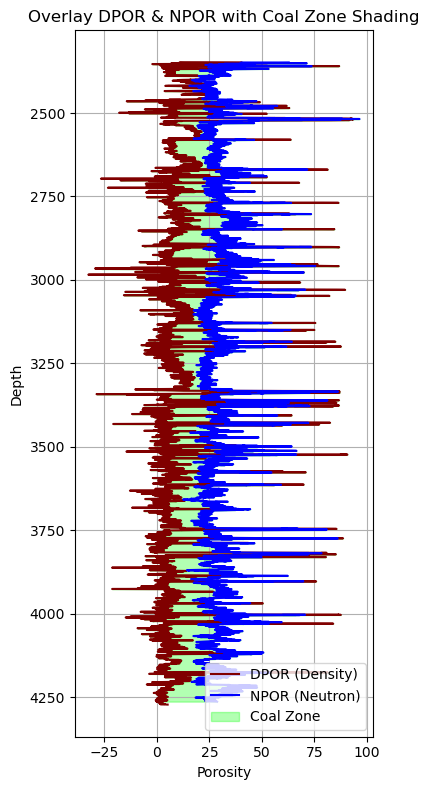

In [10]:
# 5a. Plotting for Whole Range of Depth
plot_overlay_porosity(df_full)

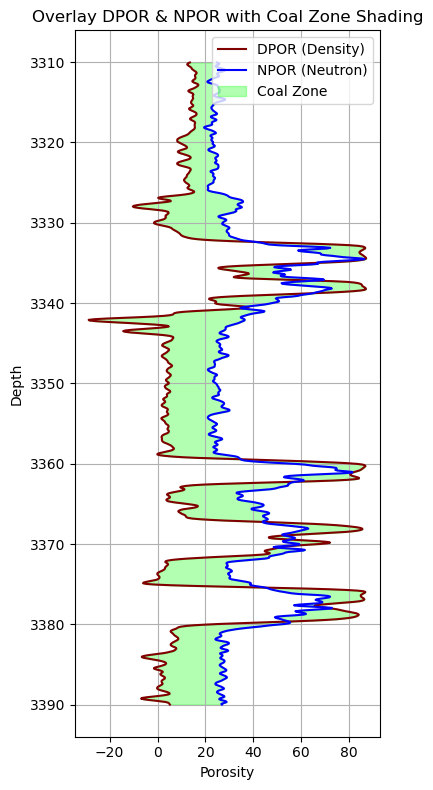

In [11]:
# 5b. Plotting for Subset depth range
plot_overlay_porosity(df_full, top=3310, base=3390)

In [12]:
# 6. Coal Intervals with Thickness

from itertools import groupby
from operator import itemgetter

coal_depths = df[criteria].index.to_list()
coal_intervals = []

for k, g in groupby(enumerate(coal_depths), lambda x: x[0] - x[1]):
    group = list(map(itemgetter(1), g))     # Index 1: Depth; so itemgetter(1)
    top = min(group)
    base = max(group)
    thickness = base - top
    if thickness > 0.5:
        coal_intervals.append({'Top(ft)': top, 'Base(ft)': base, 'Thickenss(ft)': thickness})
        
coal_df = pd.DataFrame(coal_intervals)
coal_df

""


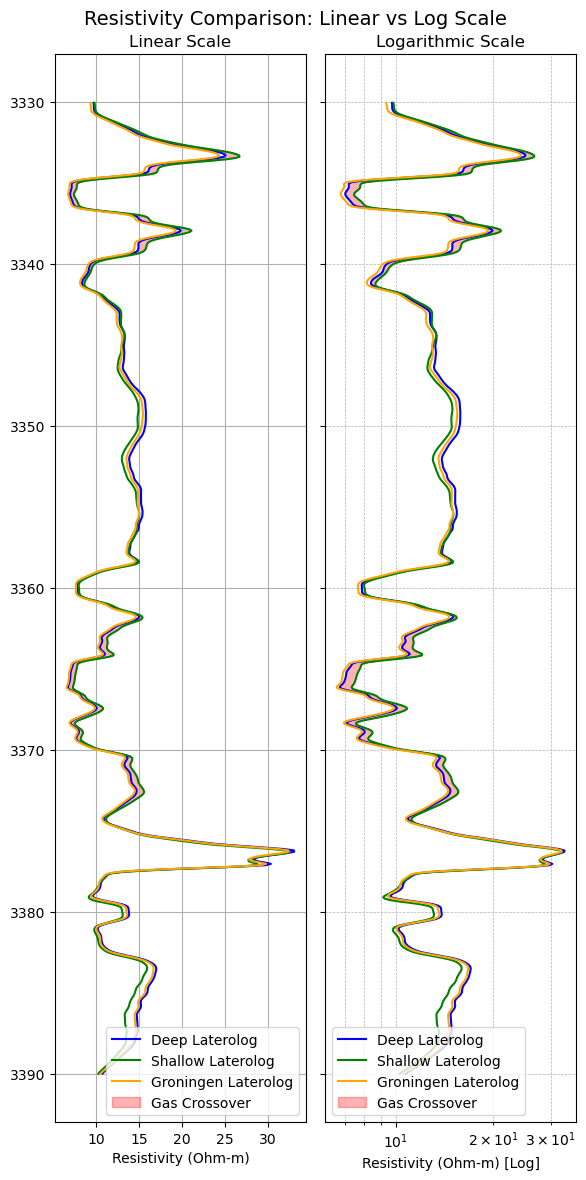

In [ ]:
# 7. Plot Coal Gas Crossover (at 3330 - 3390ft)

# 1. Load LAS and DataFrame
df = las.df()
df.index.name = "Depth"
df.index = pd.to_numeric(df.index, errors='coerce')
df = df[~df.index.isna()]
df = df[df.index >= 0]

# 2. Rename columns
df = df.rename(columns={
    "DDLL": "Deep Laterolog",
    "DSLL": "Shallow Laterolog",
    "DGLL": "Groningen Laterolog"
})

# 3. Filter depth zone
zone_df = df.loc[3390:3330][['Deep Laterolog', 'Shallow Laterolog', 'Groningen Laterolog']].dropna()
zone_df = zone_df[(zone_df > 0).all(axis=1)]  # Elak log error

if not zone_df.empty:
    fig, axes = plt.subplots(ncols=2, figsize=(6, 10), sharey=True)

    # --- LINEAR PLOT ---
    axes[0].plot(zone_df['Deep Laterolog'], zone_df.index, label='Deep Laterolog', color='blue')
    axes[0].plot(zone_df['Shallow Laterolog'], zone_df.index, label='Shallow Laterolog', color='green')
    if 'Groningen Laterolog' in zone_df.columns:
        axes[0].plot(zone_df['Groningen Laterolog'], zone_df.index, label='Groningen Laterolog', color='orange')
    
    axes[0].fill_betweenx(
        zone_df.index,
        zone_df['Deep Laterolog'],
        zone_df['Shallow Laterolog'],
        where=zone_df['Shallow Laterolog'] > zone_df['Deep Laterolog'],
        color='red', alpha=0.3, label='Gas Crossover'
    )

    axes[0].invert_yaxis()
    axes[0].set_xlabel("Resistivity (Ohm-m)")
    axes[0].set_title("Linear Scale")
    axes[0].legend()
    axes[0].grid(True)

    # --- LOG SCALE PLOT ---
    axes[1].plot(zone_df['Deep Laterolog'], zone_df.index, label='Deep Laterolog', color='blue')
    axes[1].plot(zone_df['Shallow Laterolog'], zone_df.index, label='Shallow Laterolog', color='green')
    if 'Groningen Laterolog' in zone_df.columns:
        axes[1].plot(zone_df['Groningen Laterolog'], zone_df.index, label='Groningen Laterolog', color='orange')

    axes[1].fill_betweenx(
        zone_df.index,
        zone_df['Deep Laterolog'],
        zone_df['Shallow Laterolog'],
        where=zone_df['Shallow Laterolog'] > zone_df['Deep Laterolog'],
        color='red', alpha=0.3, label='Gas Crossover'
    )

    axes[1].invert_yaxis()
    axes[1].set_xscale('log')
    axes[1].set_xlabel("Resistivity (Ohm-m) [Log]")
    axes[1].set_title("Logarithmic Scale")
    axes[1].legend()
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    fig.suptitle("Resistivity Comparison: Linear vs Log Scale", fontsize=14)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

else:
    print("No data available in this depth range.")